In [5]:
import numpy as np
import roboticstoolbox as rtb
from roboticstoolbox import DHRobot
import spatialmath as sm

In [6]:
# Extiendo la clase DHRobot para que incluya el generador de trayectorias joint y cartesiano
class DHRobotGT(DHRobot):
    # Defino algunas variables de la clase, que tienen sentido cuando se generan trayectorias
    t_ref=[]; q_ref=[]; qd_ref=[]; qdd_ref=[]; tau=[];

    def get_control_reference(self,t):
        if len(self.t_ref) == 0:
            raise ValueError("No hay trayectorias deseadas definidas")

        # busca el índice dentro del vector
        k = np.searchsorted(self.t_ref, t, side='right') - 1

        # Dejo al índice dentro del rango
        if k < 0:
            k = 0
        elif k >= len(self.t_ref):
            k = len(self.t_ref) - 1

        return self.t_ref[k],self.q_ref[k],self.qd_ref[k],self.qdd_ref[k]

    def __init__(self, *args, tacc=0.1, Ts=1E-3,vmax=np.array([2*np.pi,2*np.pi]), **kwargs):
        super().__init__(*args, **kwargs)
        self.tacc = tacc
        self.Ts = Ts
        self.vmax = vmax

    def interpoladorTrapezoidal(self,A,B,C,Tj):
        """
        Interpolador trapezoidal en zona 1 y 2

        Args
        ----
          A: punto en el que estoy
          B: punto al que estaba yendo en el segmento anterior
          C: punto al que voy
          Tj: tiempo en que se realiza el movimiento

        Returns
        --------
          q_aux: vector interpolado de posiciones
          qd_aux: vector interpolado de velocidades
          qdd_aux: vector interpolado de aceleraciones
        """
        DA = A-B
        DC = C-B

        # Zona 1
        # Generar el vector tseg para Zona 1
        tseg = np.arange(-self.tacc + self.Ts, self.tacc + self.Ts, self.Ts)

        # Calculo las referencias para zona 1
        qdd_aux = np.outer((DC/Tj+DA/self.tacc)/(2*self.tacc),np.ones(len(tseg)))
        qd_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc) / (2 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc) / (2 * self.tacc)
        q_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc)**2 / (4 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc)**2 / (4 * self.tacc) + np.outer(B,np.ones(len(tseg)))

        # Zona 2
        # Generar el vector tseg para Zona 2
        tseg = np.arange(self.tacc + self.Ts, Tj - self.tacc + 0.5* self.Ts , self.Ts)

        # Inicializar las matrices theta2p, thetap y theta
        qdd_aux = np.hstack([qdd_aux,np.zeros((len(B), len(tseg)))])   # Suponiendo que B es un vector
        qd_aux = np.hstack([qd_aux,np.outer(DC / Tj, np.ones(len(tseg)))])
        q_aux = np.hstack([q_aux,np.outer(DC / Tj, tseg) +  np.outer(B,np.ones(len(tseg)))])
        return q_aux,qd_aux,qdd_aux

    def genTrJoint(self, q_dest,Td):
        """
        Genera la trayectoria joint para un conjunto de puntos de paso

        Args
        -----
          q_dest: Matriz con los puntos de paso. Cada fila corresponde a un punto
          Td: tiempos deseados de cada movimiento

        Returns
        -------
          t: Vector de tiempo de referencia
          q: Vector de posiciones articulares de referencia
          qd: Vector de velocidades articulares de referencia
          qdd: Vector de aceleraciones articulares de referencia
          POSES: Vector de posiciones cartesianas de referencia
        """
        q = np.empty((self.nlinks,0)); qd = np.empty((self.nlinks,0)); qdd = np.empty((self.nlinks,0))
        A = q_dest[0,:];
        for i in range(len(q_dest)):
          B = q_dest[i,:]
          if i<len(q_dest)-1:
            C = q_dest[i+1,:]
          else:
            C = B
            Td[i] = 0
          Tj = np.max((np.max(np.abs(C-B)/self.vmax),Td[i],2*self.tacc))
          q_aux,qd_aux,qdd_aux = self.interpoladorTrapezoidal(A,B,C,Tj)
          q = np.hstack([q,q_aux]); qd = np.hstack([qd,qd_aux]); qdd = np.hstack([qdd,qdd_aux]);
          A = q[:,-1]
        t = np.linspace(0, q.shape[1],num=q.shape[1])*self.Ts

        # Calculo la trayectoria cartesiana deseada
        POSES = self.fkine(q.transpose()) # .extend([self.fkine(q[:,i]) for i in range(q.shape[1])])
        self.t_ref = t; self.q_ref=q.T; self.qd_ref=qd.T; self.qdd_ref=qdd.T
        self.tau = np.zeros_like(self.q_ref)
        return self.t_ref, self.q_ref, self.qd_ref, self.qdd_ref

    def genTrCart(self,POSE_dest,Td):
        """
        Genera la trayectoria cartesiana para un conjunto de puntos de paso

        Args
        ----
          POSE_dest: Lista con las POSES de paso
          Td: tiempos deseados de cada movimiento

        Returns
        -------
          t: Vector de tiempo de referencia
          q: Vector de posiciones articulares de referencia
          qd: Vector de velocidades articulares de referencia
          qdd: Vector de aceleraciones articulares de referencia
          POSES: Vector de posiciones cartesianas de referencia
        """

        POSEA = POSE_dest[0]
        POSES = []
        for i in range(len(POSE_dest)):
          POSEB = POSE_dest[i]
          if i<len(POSE_dest)-1:
            POSEC = POSE_dest[i+1]
          else:
            POSEC = POSEB
            Td[i] = 0
          A = np.concatenate((POSEA.t,POSEA.eulervec()))
          B = np.concatenate((POSEB.t,POSEB.eulervec()))
          C = np.concatenate((POSEC.t,POSEC.eulervec()))
          Tj = np.max([Td[i],2*self.tacc])

          pos,_,_ = self.interpoladorTrapezoidal(A,B,C,Tj)
          POSES.extend([sm.SE3(pos[0:3,j])*sm.SE3.EulerVec(pos[3:,i]) for j in range(pos.shape[1])])

          POSEA = POSES[-1]

        q = np.zeros((len(POSES),self.nlinks))
        for i in range(len(POSES)):
          q[i,:],_ = self.ikine_a(POSES[i])

        # Obtengo la velocidad articular derivando numéricamente
        qd = np.diff(q, axis=0) / self.Ts
        # Ajustar la longitud de qd para que coincida con q
        qd = np.vstack([qd, np.zeros(self.nlinks,)])

        # Obtengo la aceleración articular derivando numéricamente
        qdd = np.diff(qd, axis=0) / self.Ts
        # Ajustar la longitud de qdd para que coincida con qd
        qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

        t = np.linspace(0, len(q),num=len(q))*self.Ts
        self.t_ref = t; self.q_ref=q; self.qd_ref=qd; self.qdd_ref=qdd
        self.tau = np.zeros_like(self.q_ref)
        return self.t_ref, self.q_ref, self.qd_ref, self.qdd_ref

In [7]:
class myCobot320(DHRobotGT):
  def __init__(self,*args,**kwargs):
    # Definición de los enlaces usando parámetros DH
    
    eje1 = rtb.RevoluteDH(alpha=-np.pi/2,a=0,d=173.9,offset=0,qlim=[-170*np.pi/180,170*np.pi/180])
    eje2 = rtb.RevoluteDH(alpha=0,a=135,d=0,offset=-np.pi/2,qlim=[-120*np.pi/180,120*np.pi/180])
    eje3 = rtb.RevoluteDH(alpha=0,a=120,d=0,offset=0,qlim=[-148*np.pi/180,148*np.pi/180]) 
    eje4 = rtb.RevoluteDH(alpha=np.pi/2,a=0,d=88.78,offset=np.pi/2,qlim=[-120*np.pi/180,135*np.pi/180])
    eje5 = rtb.RevoluteDH(alpha=-np.pi/2,a=0,d=95,offset=0,qlim=[-169*np.pi/180,169*np.pi/180])    
    eje6 = rtb.RevoluteDH(alpha=0,a=0,d=65.5,offset=0,qlim=[-180*np.pi/180,180*np.pi/180])
    
    # Crear la estructura del robot
    super().__init__(*args,[eje1, eje2, eje3, eje4, eje5, eje6], name='myCobot320',gravity = np.array([0, 0, -9.8]),**kwargs)



In [8]:
cobot = myCobot320()
print(cobot)

DHRobot: myCobot320, 6 joints (RRRRRR), dynamics, standard DH parameters
┌───────────┬───────┬─────┬────────┬─────────┬────────┐
│    θⱼ     │  dⱼ   │ aⱼ  │   ⍺ⱼ   │   q⁻    │   q⁺   │
├───────────┼───────┼─────┼────────┼─────────┼────────┤
│  q1       │ 173.9 │   0 │ -90.0° │ -170.0° │ 170.0° │
│  q2 - 90° │     0 │ 135 │   0.0° │ -120.0° │ 120.0° │
│  q3       │     0 │ 120 │   0.0° │ -148.0° │ 148.0° │
│  q4 + 90° │ 88.78 │   0 │  90.0° │ -120.0° │ 135.0° │
│  q5       │    95 │   0 │ -90.0° │ -169.0° │ 169.0° │
│  q6       │  65.5 │   0 │   0.0° │ -180.0° │ 180.0° │
└───────────┴───────┴─────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘



# Cinemática Directa

## Ternas y matrices de rototraslación

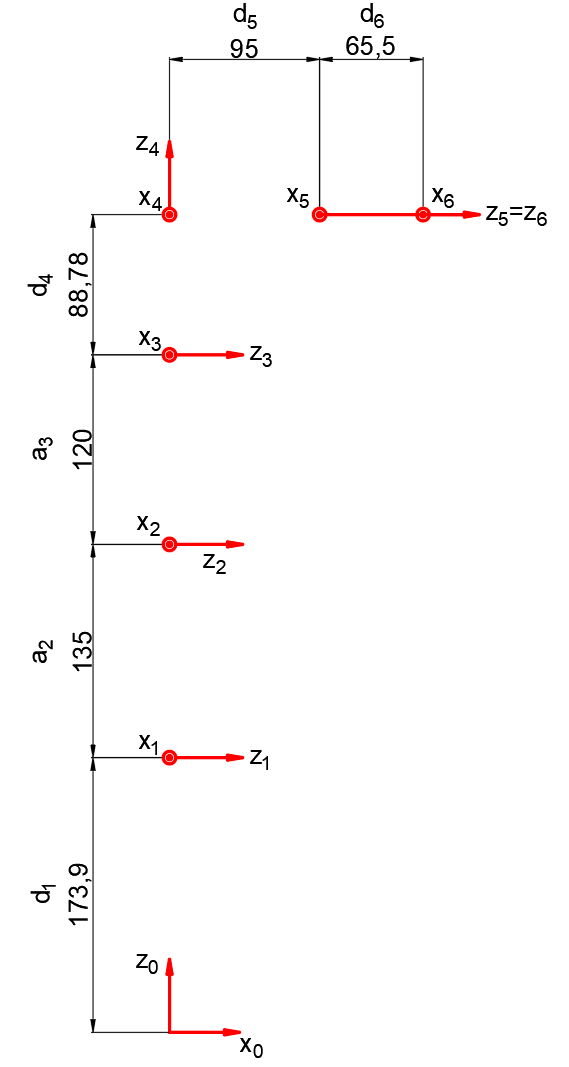

$$A^1_0 = \begin{bmatrix}
 c \theta_1&  0&  -s \theta_1&  0\\
 s \theta_1&  0&  c \theta_1&  0\\
 0&  -1&  0&  d_1\\
0 &  0&  0& 1
\end{bmatrix}
\quad
A^2_1 = \begin{bmatrix}
 c \theta_2&  -s \theta_2&  0&  a_2 c\theta_2\\
 s \theta_2&  c\theta_2&  0&  a_2 s\theta_2\\
 0&  0&  1&  0\\
0 &  0&  0& 1
\end{bmatrix} 
\quad
A^3_2 = \begin{bmatrix}
 c \theta_3&  -s \theta_3&  0&  a_3 c\theta_3\\
 s \theta_3&  c\theta_3&  0&  a_3 s\theta_3\\
 0&  0&  1&  0\\
0 &  0&  0& 1
\end{bmatrix} $$

$$A^4_3 = \begin{bmatrix}
 c \theta_4&  0&  s \theta_4&  0\\
 s \theta_4&  0&  -c \theta_4&  0\\
 0&  1&  0&  d_4\\
0 &  0&  0& 1
\end{bmatrix}
\quad
A^5_4 = \begin{bmatrix}
 c \theta_5&  0&  -s \theta_5&  0\\
 s \theta_5&  0&  c \theta_5&  0\\
 0&  -1&  0&  d_5\\
0 &  0&  0& 1
\end{bmatrix}
\quad
A^6_5 = \begin{bmatrix}
 c \theta_6&  -s \theta_6&  0&  0\\
 s \theta_6&  c\theta_6&  0&  0\\
 0&  0&  1&  d_6\\
0 &  0&  0& 1
\end{bmatrix} $$

# Cinemática Inversa

Definimos las variables y matrices previas:

In [9]:
import sympy as smp

theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = smp.symbols('theta_1:7')
p_x, p_y, p_z = smp.symbols('p_x p_y p_z')
n_x, n_y, n_z = smp.symbols('n_x n_y n_z')
s_x, s_y, s_z = smp.symbols('s_x s_y s_z')
a_x, a_y, a_z = smp.symbols('a_x a_y a_z')
d_1, d_4, d_5, d_6 = smp.symbols('d_1 d_4 d_5 d_6')
a_2, a_3 = smp.symbols('a_2 a_3')

A10 = smp.Matrix([
    [smp.cos(theta_1), 0, -smp.sin(theta_1), 0],
    [smp.sin(theta_1), 0, smp.cos(theta_1), 0],
    [0, -1, 0, d_1],
    [0, 0, 0, 1]])

A21 = smp.Matrix([
    [smp.cos(theta_2), -smp.sin(theta_2), 0, a_2 * smp.cos(theta_2)],
    [smp.sin(theta_2), smp.cos(theta_2), 0, a_2 * smp.sin(theta_2)],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

A32 = smp.Matrix([
    [smp.cos(theta_3), -smp.sin(theta_3), 0, a_3 * smp.cos(theta_3)],
    [smp.sin(theta_3), smp.cos(theta_3), 0, a_3 * smp.sin(theta_3)],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

A43 = smp.Matrix([
    [smp.cos(theta_4), 0, smp.sin(theta_4), 0],
    [smp.sin(theta_4), 0, -smp.cos(theta_4), 0],
    [0, 1, 0, d_4],
    [0, 0, 0, 1]
])

A54 = smp.Matrix([
    [smp.cos(theta_5), 0, -smp.sin(theta_5), 0],
    [smp.sin(theta_5), 0, smp.cos(theta_5), 0],
    [0, -1, 0, d_5],
    [0, 0, 0, 1]
])

A65 = smp.Matrix([
    [smp.cos(theta_6), -smp.sin(theta_6), 0, 0],
    [smp.sin(theta_6), smp.cos(theta_6), 0, 0],
    [0, 0, 1, d_6],
    [0, 0, 0, 1]
])

POSE = smp.Matrix([
    [n_x, s_x, a_x, p_x],
    [n_y, s_y, a_y, p_y],
    [n_z, s_z, a_z, p_z],
    [0, 0, 0, 1]
])

Planteamos 

$$A^6_0 = A^1_0 \, A^2_1 \, A^3_2 \, A^4_3 \, A^5_4 \, A^6_5$$

$${A^1_0}^{-1} \, A^6_0 = A^2_1 \, A^3_2 \, A^4_3 \, A^5_4 \, A^6_5$$

según se propone [acá](https://collaborative-robot.org/articles/1-8).

## $q_1$

Lo primero que se puede calcular es $\theta_1$ y $\theta_5$. Para esto analizamos la tercera y cuarta columna de la tercera fila, $A_{33}$ y $A_{34}$ ([2,2] y [2,3] en índices de python). Obtenemos entonces un sistema de 2x2:

In [10]:
eq1 = smp.Eq((A21*A32*A43*A54*A65)[2,2], (A10.inv()*POSE)[2,2])
eq2 = smp.Eq((A21*A32*A43*A54*A65)[2,3], (A10.inv()*POSE)[2,3])

from IPython.display import Markdown as md

md(f'$${smp.latex(eq1)} \\\\[5pt] {smp.latex(eq2)}$$')

$$\cos{\left(\theta_{5} \right)} = - a_{x} \sin{\left(\theta_{1} \right)} + a_{y} \cos{\left(\theta_{1} \right)} \\[5pt] d_{4} + d_{6} \cos{\left(\theta_{5} \right)} = - p_{x} \sin{\left(\theta_{1} \right)} + p_{y} \cos{\left(\theta_{1} \right)}$$

De la primera ecuación despejamos $\theta_5$ tomando $\mathrm{arc cos}$:

In [11]:
theta_5_exp = smp.acos(eq1.rhs)
md(f'$$\\theta_5 = {smp.latex(theta_5_exp)}$$')

$$\theta_5 = \operatorname{acos}{\left(- a_{x} \sin{\left(\theta_{1} \right)} + a_{y} \cos{\left(\theta_{1} \right)} \right)}$$

Esta expresión la sustituimos en la segunda ecuación y nos queda una ecuación que únicamente depende de $\theta_1$.

In [12]:
eq_theta1 = eq2.subs(theta_5, theta_5_exp)
eq_theta1

Eq(d_4 + d_6*(-a_x*sin(theta_1) + a_y*cos(theta_1)), -p_x*sin(theta_1) + p_y*cos(theta_1))

La solución obtenida mediante sympy es:

In [13]:
sol_q1 = smp.solve(eq_theta1, theta_1)[0].simplify()
md(f'$$\\theta_1 = {smp.latex(sol_q1)}$$')

$$\theta_1 = - 2 \operatorname{atan}{\left(\frac{- a_{x} d_{6} + p_{x} + \sqrt{a_{x}^{2} d_{6}^{2} - 2 a_{x} d_{6} p_{x} + a_{y}^{2} d_{6}^{2} - 2 a_{y} d_{6} p_{y} - d_{4}^{2} + p_{x}^{2} + p_{y}^{2}}}{- a_{y} d_{6} + d_{4} + p_{y}} \right)}$$

Esto difiere del atan2:

$$\theta_1 = \arctan2\left(d_4 \, ; \, \mathrm{conf_1} \cdot \sqrt{(p_x - a_x d_6)^2 + (p_y - a_y d_6)^2 - d_4^2}\right) - \arctan2\left(p_y - a_y d_6\, ; \, a_x d_6 - p_x\right)$$

Aunque el radicando es el mismo. La solución de sympy no lo toma como discriminante y tampoco considera $\mathrm{atan2}$. 

Podemos probar valores numéricos para ver cómo se comparan.

In [14]:
# Los valores son arbitrarios, salvo por aquellas que son parámetros constructivos.
num_vals = {
    n_x: 0.18, s_x: 0.91, a_x: 1.84, p_x: 28,
    n_y: 0.37, s_y: 0.71, a_y: 1.27, p_y: 50,
    n_z: 0.43, s_z: 0.08, a_z: 0.65, p_z: 14,
    d_1: 173.9, a_2: 135, a_3: 120, d_4: 88.78, d_5: 95, d_6: 65.5
}

# Expresión obtenida con sympy: la raíz se suma
result = smp.N(sol_q1.subs(num_vals))
result

1.47162975995091

Planteamos la suma y resta del radicando obtenido con sympy:

In [15]:
expr_0 = -2 * smp.atan(
    (-a_x * d_6 + p_x + smp.sqrt(
        a_x**2 * d_6**2 - 2 * a_x * d_6 * p_x + a_y**2 * d_6**2 - 2 * a_y * d_6 * p_y - d_4**2 + p_x**2 + p_y**2
    )) / (-a_y * d_6 + d_4 + p_y)
)

expr_1 = -2 * smp.atan(
    (-a_x * d_6 + p_x - smp.sqrt(
        a_x**2 * d_6**2 - 2 * a_x * d_6 * p_x + a_y**2 * d_6**2 - 2 * a_y * d_6 * p_y - d_4**2 + p_x**2 + p_y**2
    )) / (-a_y * d_6 + d_4 + p_y)
)

In [16]:
md(f'Sympy: raíz suma $\\Rightarrow \\quad \\theta_1 = {smp.latex(smp.N(expr_0.subs(num_vals)))}$')

Sympy: raíz suma $\Rightarrow \quad \theta_1 = 1.47162975995091$

In [17]:
md(f'Sympy: raíz resta $\\Rightarrow \\quad \\theta_1 = {smp.latex(smp.N(expr_1.subs(num_vals)))}$')

Sympy: raíz resta $\Rightarrow \quad \theta_1 = 2.35873455214282$

Lo comparamos con la expresión con $\mathrm{atan2}$:

In [ ]:
# Variables numéricas (para usar en numpy por ejemplo)
[nx_val, sx_val, ax_val, px_val, 
 ny_val, sy_val, ay_val, py_val, 
 nz_val, sz_val, az_val, pz_val, 
 d1_val, a2_val, a3_val, d4_val, d5_val, d6_val] = [num_vals[key] for key in num_vals.keys()]

In [19]:
discr = (px_val - ax_val * d6_val)**2 + (py_val - ay_val * d6_val)**2 - d4_val**2
q1_p = np.arctan2(d4_val, 1 * np.sqrt(discr)) - np.arctan2(py_val - ay_val * d6_val, ax_val * d6_val - px_val)
q1_n = np.arctan2(d4_val, -1 * np.sqrt(discr)) - np.arctan2(py_val - ay_val * d6_val, ax_val * d6_val - px_val)

print(f'atan2: conf1 = 1 => {q1_p}')
print(f'atan2: conf1 = -1 => {q1_n}')

atan2: conf1 = 1 => 1.4716297599509096
atan2: conf1 = -1 => 2.3587345521428196


## $q_5$

Igualamos la fila 3, columnas 1 y 2 para obtener las siguientes ecuaciones:

In [20]:
eq3 = smp.Eq((A21*A32*A43*A54*A65)[2,0], (A10.inv()*POSE)[2,0])
eq4 = smp.Eq((A21*A32*A43*A54*A65)[2,1], (A10.inv()*POSE)[2,1])

md(f'$${smp.latex(eq3)} \\\\[5pt] {smp.latex(eq4)}$$')

$$\sin{\left(\theta_{5} \right)} \cos{\left(\theta_{6} \right)} = - n_{x} \sin{\left(\theta_{1} \right)} + n_{y} \cos{\left(\theta_{1} \right)} \\[5pt] - \sin{\left(\theta_{5} \right)} \sin{\left(\theta_{6} \right)} = - s_{x} \sin{\left(\theta_{1} \right)} + s_{y} \cos{\left(\theta_{1} \right)}$$

Elevamos al cuadrado y sumamos las ecuaciones para eliminar $\theta_6$:

In [21]:
eq34_aux = smp.Eq(eq3.lhs**2 + eq4.lhs**2, eq3.rhs**2 + eq4.rhs**2)
eq34_aux.simplify()

Eq(sin(theta_5)**2, (n_x*sin(theta_1) - n_y*cos(theta_1))**2 + (s_x*sin(theta_1) - s_y*cos(theta_1))**2)

Nos queda la expresión para $\sin(\theta_5)$.

In [22]:
md(f'$$\\sin(\\theta_5) = \\pm \\sqrt{{{smp.latex(eq34_aux.rhs)}}}$$')

$$\sin(\theta_5) = \pm \sqrt{\left(- n_{x} \sin{\left(\theta_{1} \right)} + n_{y} \cos{\left(\theta_{1} \right)}\right)^{2} + \left(- s_{x} \sin{\left(\theta_{1} \right)} + s_{y} \cos{\left(\theta_{1} \right)}\right)^{2}}$$

En el análisis de $q_1$ habíamos despejado $\cos{(\theta_2)}$. Con estos datos usamos $\arctan 2$ y obtenemos $q_5$. El $\pm$ en el despeje de $\sin{(\theta_5)}$ indica las posibles configuraciones.

In [23]:
md(f'$$ q_5 = \\arctan 2(\pm{smp.latex(smp.sqrt(eq34_aux.rhs))}, {smp.latex(eq1.rhs)}) $$')

$$ q_5 = \arctan 2(\pm\sqrt{\left(- n_{x} \sin{\left(\theta_{1} \right)} + n_{y} \cos{\left(\theta_{1} \right)}\right)^{2} + \left(- s_{x} \sin{\left(\theta_{1} \right)} + s_{y} \cos{\left(\theta_{1} \right)}\right)^{2}}, - a_{x} \sin{\left(\theta_{1} \right)} + a_{y} \cos{\left(\theta_{1} \right)}) $$

## $q_6$

Conocidas $q_1$ y $q_5$, se puede plantear $\arctan 2$ en las ecuaciones usadas para hallar $q_5$.

In [24]:
md(f'$$ \\cos(\\theta_6) = {smp.latex(smp.solve(eq3, smp.cos(theta_6))[0])} \\\\[10pt] \
    \\sin(\\theta_6) = {smp.latex(smp.solve(eq4, smp.sin(theta_6))[0])} \\\\[10pt] \
    \\theta_6 = {smp.latex(smp.atan2(smp.solve(eq4, smp.sin(theta_6))[0], smp.solve(eq3, smp.cos(theta_6))[0]))}$$')

$$ \cos(\theta_6) = \frac{- n_{x} \sin{\left(\theta_{1} \right)} + n_{y} \cos{\left(\theta_{1} \right)}}{\sin{\left(\theta_{5} \right)}} \\[10pt]     \sin(\theta_6) = \frac{s_{x} \sin{\left(\theta_{1} \right)} - s_{y} \cos{\left(\theta_{1} \right)}}{\sin{\left(\theta_{5} \right)}} \\[10pt]     \theta_6 = \operatorname{atan}_{2}{\left(\frac{s_{x} \sin{\left(\theta_{1} \right)} - s_{y} \cos{\left(\theta_{1} \right)}}{\sin{\left(\theta_{5} \right)}},\frac{- n_{x} \sin{\left(\theta_{1} \right)} + n_{y} \cos{\left(\theta_{1} \right)}}{\sin{\left(\theta_{5} \right)}} \right)}$$

Habrá una indeterminación cuando $\sin(\theta_5) = 0$. Como los topes no permiten llegar a $\theta_5 = \pi$, la singularidad solo ocurre para $\theta_5 = 0$.

## $q_{234}$

Dado que $q_2$, $q_3$ y $q_4$ están acopladas en todas las ecuaciones restantes, calculamos primero $\theta_2 + \theta_3 + \theta_4$ y luego buscamos relaciones lineales con las variables articulares restantes. De la primera y segunda fila de la tercera columna se obtiene:

In [25]:
eq5 = smp.Eq((A21*A32*A43*A54*A65)[0,2].simplify(), (A10.inv()*POSE)[0,2].simplify())
eq6 = smp.Eq((A21*A32*A43*A54*A65)[1,2].simplify(), (A10.inv()*POSE)[1,2])

md(f'$${smp.latex(eq5)} \\\\[5pt] {smp.latex(eq6)}$$')

$$- \sin{\left(\theta_{5} \right)} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} = a_{x} \cos{\left(\theta_{1} \right)} + a_{y} \sin{\left(\theta_{1} \right)} \\[5pt] - \sin{\left(\theta_{5} \right)} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} = - a_{z}$$

Dividiendo por $-\sin(\theta_5)$ planteamos $\arctan 2$:

In [26]:
md(f'$$\\theta_2 + \\theta_3 + \\theta_4 = {smp.latex(smp.atan2(smp.solve(eq6, smp.sin(theta_2 + theta_3 + theta_4))[0], smp.solve(eq5, smp.cos(theta_2 + theta_3 + theta_4))[0]))}$$')

$$\theta_2 + \theta_3 + \theta_4 = \operatorname{atan}_{2}{\left(\frac{a_{z}}{\sin{\left(\theta_{5} \right)}},- \frac{a_{x} \cos{\left(\theta_{1} \right)} + a_{y} \sin{\left(\theta_{1} \right)}}{\sin{\left(\theta_{5} \right)}} \right)}$$

## $q_3$

Armamos las ecuaciones con las filas 1 y 2 de la columna 4:

In [27]:
eq7 = smp.Eq((A21*A32*A43*A54*A65)[0,3].simplify(), (A10.inv()*POSE)[0,3].simplify())
eq8 = smp.Eq((A21*A32*A43*A54*A65)[1,3].simplify(), (A10.inv()*POSE)[1,3])

md(f'$${smp.latex(eq7)} \\\\[5pt] {smp.latex(eq8)}$$')

$$a_{2} \cos{\left(\theta_{2} \right)} + a_{3} \cos{\left(\theta_{2} + \theta_{3} \right)} + d_{5} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} - d_{6} \sin{\left(\theta_{5} \right)} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} = p_{x} \cos{\left(\theta_{1} \right)} + \frac{p_{y} \sin{\left(2 \theta_{1} \right)}}{2 \cos{\left(\theta_{1} \right)}} \\[5pt] a_{2} \sin{\left(\theta_{2} \right)} + a_{3} \sin{\left(\theta_{2} + \theta_{3} \right)} - d_{5} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} - d_{6} \sin{\left(\theta_{5} \right)} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} = d_{1} - p_{z}$$

Pasamos los términos afectados por $(\theta_2 + \theta_3 + \theta_4)$ al otro miembro.

In [28]:
A, B = smp.symbols('A B')
A_expr = -d_5*smp.sin(theta_2 + theta_3 + theta_4) + d_6*smp.sin(theta_5)*smp.cos(theta_2 + theta_3 + theta_4)
B_expr = d_5*smp.cos(theta_2 + theta_3 + theta_4) + d_6*smp.sin(theta_5)*smp.sin(theta_2 + theta_3 + theta_4)

eq7_0 = smp.Eq(eq7.rhs + A_expr, eq7.lhs + A_expr).simplify()
eq8_0 = smp.Eq(eq8.rhs + B_expr, eq8.lhs + B_expr).simplify()

md(f'$${smp.latex(eq7_0)} \\\\[5pt] {smp.latex(eq8_0)}$$')

$$a_{2} \cos{\left(\theta_{2} \right)} + a_{3} \cos{\left(\theta_{2} + \theta_{3} \right)} = - d_{5} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + d_{6} \sin{\left(\theta_{5} \right)} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + p_{x} \cos{\left(\theta_{1} \right)} + p_{y} \sin{\left(\theta_{1} \right)} \\[5pt] a_{2} \sin{\left(\theta_{2} \right)} + a_{3} \sin{\left(\theta_{2} + \theta_{3} \right)} = d_{1} + d_{5} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + d_{6} \sin{\left(\theta_{5} \right)} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} - p_{z}$$

Sustuituimos al miembro derecho de cada ecuación por $A$ y $B$ respectivamente.

In [29]:
A_sus = eq7_0.rhs
B_sus = eq8_0.rhs
eq7_s = eq7_0.subs(A_sus, A)
eq8_s = eq8_0.subs(B_sus, B)

md(f'$${smp.latex(eq7_s)} \\\\[5pt] {smp.latex(eq8_s)} \\\\[5pt]\
   A = {smp.latex(A_sus)} \\\\[5pt] B = {smp.latex(B_sus)}$$')

$$a_{2} \cos{\left(\theta_{2} \right)} + a_{3} \cos{\left(\theta_{2} + \theta_{3} \right)} = A \\[5pt] a_{2} \sin{\left(\theta_{2} \right)} + a_{3} \sin{\left(\theta_{2} + \theta_{3} \right)} = B \\[5pt]   A = - d_{5} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + d_{6} \sin{\left(\theta_{5} \right)} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + p_{x} \cos{\left(\theta_{1} \right)} + p_{y} \sin{\left(\theta_{1} \right)} \\[5pt] B = d_{1} + d_{5} \cos{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} + d_{6} \sin{\left(\theta_{5} \right)} \sin{\left(\theta_{2} + \theta_{3} + \theta_{4} \right)} - p_{z}$$

Elevamos al cuadrado miembro a miembro y luego sumamos:

In [30]:
eq78 = smp.Eq(eq7_s.lhs**2 + eq8_s.lhs**2, eq7_s.rhs**2 + eq8_s.rhs**2)
md(f'$${smp.latex(eq78.simplify())}$$')

$$A^{2} + B^{2} = a_{2}^{2} + 2 a_{2} a_{3} \cos{\left(\theta_{3} \right)} + a_{3}^{2}$$

Despejamos $\cos {(\theta_3)}$. 

In [31]:
md(f'$$\\cos \\, (\\theta_3) = {smp.latex(smp.solve(eq78.simplify(), smp.cos(theta_3))[0])}$$') 

$$\cos \, (\theta_3) = \frac{A^{2} + B^{2} - a_{2}^{2} - a_{3}^{2}}{2 a_{2} a_{3}}$$

Podemos plantear una configuración posible de acuerdo a esta variable articular. Agregando el signo y $\sin (\theta_3)$ por relación pitagórica:

$$\theta_3 = \mathrm{atan_2} \left( \pm \sqrt{1 - \cos^2{(\theta_3)}} \, , \, \cos{(\theta_3)} \right )$$

## $q_2$

Usamos las mismas ecuaciones que para $q_3$. Primero las reescribimos aplicando las propiedades de seno y coseno de suma de ángulos:

In [32]:
eq7_2 = smp.Eq(a_2*smp.cos(theta_2) + a_3*(smp.cos(theta_2)*smp.cos(theta_3) - smp.sin(theta_2)*smp.sin(theta_3)), A)
eq8_2 = smp.Eq(a_2*smp.sin(theta_2) + a_3*(smp.sin(theta_2)*smp.cos(theta_3) + smp.cos(theta_2)*smp.sin(theta_3)), B)

md(f'$${smp.latex(eq7_2)} \\\\[5pt] {smp.latex(eq8_2)}$$')

$$a_{2} \cos{\left(\theta_{2} \right)} + a_{3} \left(- \sin{\left(\theta_{2} \right)} \sin{\left(\theta_{3} \right)} + \cos{\left(\theta_{2} \right)} \cos{\left(\theta_{3} \right)}\right) = A \\[5pt] a_{2} \sin{\left(\theta_{2} \right)} + a_{3} \left(\sin{\left(\theta_{2} \right)} \cos{\left(\theta_{3} \right)} + \sin{\left(\theta_{3} \right)} \cos{\left(\theta_{2} \right)}\right) = B$$

De la primera ecuación despejamos $\cos{(\theta_2)}$:


In [33]:
md(f'$$\\cos \\, (\\theta_2) = {smp.latex(smp.solve(eq7_2, smp.cos(theta_2))[0])}$$')

$$\cos \, (\theta_2) = \frac{A + a_{3} \sin{\left(\theta_{2} \right)} \sin{\left(\theta_{3} \right)}}{a_{2} + a_{3} \cos{\left(\theta_{3} \right)}}$$

Sustituimos esta expresión en la segunda ecuación:

In [34]:
md(f'$$ {smp.latex(eq8_2.subs(smp.cos(theta_2), smp.solve(eq7_2, smp.cos(theta_2))[0]).simplify())} $$')

$$ B = \frac{A a_{3} \sin{\left(\theta_{3} \right)} + a_{2}^{2} \sin{\left(\theta_{2} \right)} + 2 a_{2} a_{3} \sin{\left(\theta_{2} \right)} \cos{\left(\theta_{3} \right)} + a_{3}^{2} \sin{\left(\theta_{2} \right)}}{a_{2} + a_{3} \cos{\left(\theta_{3} \right)}} $$

Habiendo desacoplado los senos y cosenos de $\theta_2$, despejamos $\sin{(\theta_2)}$:

In [35]:
md(f'$${smp.latex(smp.sin(theta_2))} = {smp.latex(smp.solve(eq8_2.subs(smp.cos(theta_2), smp.solve(eq7_2, smp.cos(theta_2))[0]).simplify(), smp.sin(theta_2))[0].simplify())}$$')

$$\sin{\left(\theta_{2} \right)} = \frac{- A a_{3} \sin{\left(\theta_{3} \right)} + B a_{2} + B a_{3} \cos{\left(\theta_{3} \right)}}{a_{2}^{2} + 2 a_{2} a_{3} \cos{\left(\theta_{3} \right)} + a_{3}^{2}}$$

Repetimos el razonamiento para $\cos{(\theta_2)}$.

In [36]:
md(f'$${smp.latex(smp.cos(theta_2))} = {smp.latex(smp.solve(eq7_2.subs(smp.sin(theta_2), smp.solve(eq8_2, smp.sin(theta_2))[0]).simplify(), smp.cos(theta_2))[0].simplify())}$$')

$$\cos{\left(\theta_{2} \right)} = \frac{A a_{2} + A a_{3} \cos{\left(\theta_{3} \right)} + B a_{3} \sin{\left(\theta_{3} \right)}}{a_{2}^{2} + 2 a_{2} a_{3} \cos{\left(\theta_{3} \right)} + a_{3}^{2}}$$

Finalmente, aplicamos $\mathrm{atan_2}$:

$$\theta_2 = \mathrm{atan_2} \left(\sin{(\theta_2)} \, , \, \cos{(\theta_2)} \right)$$

## $q_4$

Con $\theta_{234}$ despejamos $\theta_4$.

$$\theta_4 = \theta_{234} - \theta_2 - \theta_3$$

# Anexo

Cálculo de $\theta_3$ siguiendo el paper linkeado antes.

$$A^2_1 \, A^3_2 \, A^4_3 = {A^1_0}^{-1} \, A^6_0 \, {A^6_5}^{-1} \, {A^5_4}^{-1}$$

De las filas 1 y 2 de la cuarta columna obtenemos las siguientes ecuaciones:

In [37]:
eq9 = smp.Eq((A21*A32*A43)[0, 3].simplify(),(A10.inv()*POSE*A65.inv()*A54.inv())[0, 3].simplify())
eq10 = smp.Eq((A21*A32*A43)[1, 3].simplify(),(A10.inv()*POSE*A65.inv()*A54.inv())[1, 3].simplify())
md(f'$${smp.latex(eq9)} \\\\[10pt] {smp.latex(eq10)}$$')

$$a_{2} \cos{\left(\theta_{2} \right)} + a_{3} \cos{\left(\theta_{2} + \theta_{3} \right)} = \frac{\frac{d_{5} \left(\left(2 n_{x} \cos^{2}{\left(\theta_{1} \right)} + n_{y} \sin{\left(2 \theta_{1} \right)}\right) \sin{\left(\theta_{6} \right)} + \left(2 s_{x} \cos^{2}{\left(\theta_{1} \right)} + s_{y} \sin{\left(2 \theta_{1} \right)}\right) \cos{\left(\theta_{6} \right)}\right)}{2} - \frac{d_{6} \cdot \left(2 a_{x} \cos^{2}{\left(\theta_{1} \right)} + a_{y} \sin{\left(2 \theta_{1} \right)}\right)}{2} + p_{x} \cos^{2}{\left(\theta_{1} \right)} + \frac{p_{y} \sin{\left(2 \theta_{1} \right)}}{2}}{\cos{\left(\theta_{1} \right)}} \\[10pt] a_{2} \sin{\left(\theta_{2} \right)} + a_{3} \sin{\left(\theta_{2} + \theta_{3} \right)} = a_{z} d_{6} + d_{1} - d_{5} \left(n_{z} \sin{\left(\theta_{6} \right)} + s_{z} \cos{\left(\theta_{6} \right)}\right) - p_{z}$$

Las elevamos al cuadrado y sumamos entre sí:

In [38]:
eq910 = smp.Eq((eq9.lhs**2 + eq10.lhs**2).simplify(), (eq9.rhs**2 + eq10.rhs**2).simplify())
eq910

Eq(a_2**2 + 2*a_2*a_3*cos(theta_3) + a_3**2, ((a_z*d_6 + d_1 - d_5*(n_z*sin(theta_6) + s_z*cos(theta_6)) - p_z)**2*cos(theta_1)**2 + (d_5*((2*n_x*cos(theta_1)**2 + n_y*sin(2*theta_1))*sin(theta_6) + (2*s_x*cos(theta_1)**2 + s_y*sin(2*theta_1))*cos(theta_6)) - d_6*(2*a_x*cos(theta_1)**2 + a_y*sin(2*theta_1)) + 2*p_x*cos(theta_1)**2 + p_y*sin(2*theta_1))**2/4)/cos(theta_1)**2)

La expresión difiere de la que usamos para $\theta_3$ antes. El miembro izquierdo es igual, en el derecho aparece una indeterminación con el ángulo $\theta_1$ que antes no estaba. Además ahora los ángulos que necestiamos son $\theta_5$ y $\theta_6$ en vez de $\theta_{234}$. $\theta_1$ aparece en los 2 planteos.

Si comparamos numéricamente el miembro derecho de este último planteo con el del anterior ($A^2 + B^2$) notamos diferencias. Quizás sea necesaria alguna sustitución para salvar la indeterminación de $\theta_1$ y lograr que los 2 caminos conduzcan al mismo resultado.

In [39]:
prueba_a = eq910.rhs
prueba_b = (A_sus**2 + B_sus**2).simplify()

In [40]:
num_vals2 = {
    n_x: 0.18, s_x: 0.91, a_x: 1.84, p_x: 28,
    n_y: 0.37, s_y: 0.71, a_y: 1.27, p_y: 50,
    n_z: 0.43, s_z: 0.08, a_z: 0.65, p_z: 14,
    d_1: 173.9, a_2: 135, a_3: 120, d_4: 88.78, d_5: 95, d_6: 65.5,
    theta_1 : np.pi/2, theta_6 : 0.5, theta_5 : 0.5, theta_2 : 0.5, theta_3 : 0.5, theta_4 : 0.5
}

In [41]:
prueba_a.subs(num_vals2).simplify()

32890.7424927710

In [42]:
prueba_b.subs(num_vals2).simplify()

40991.4374354902

In [43]:
# pos_ini = np.array([np.pi/2, 0, 0, 0, 0, 0])
# cobot.plot(q=pos_ini)

In [44]:
# cobot.manipulability(q=pos_ini)